    # 06. Ensemble Learning and Random Forests

    # 06. Ensemble Learning and Random Forests
        ## 6-1. Setup
        ## 6-2. Voting classifiers
        ## 6-3. Bagging ensembles
            ### 6-3-1. scikit-learn의 Bagging과 pasting
            ### 6-3-2. oob 평가
        ## 6-4. 랜덤 패치와 랜덤 서브스페이스
        ## 6-5. Random Forests
            ### 6-5-1. Feature importance
        ## 6-6. Boosting
            ### 6-6-1. AdaBoost
            ### 6-6-2. Gradient Boosting
            ### 6-6-3. Gradient Boosting with Early stopping
            ### 6-6-4. XGBoost
            ### 6-6-5. Stacking
        ## 6-7. Exercise

## 6-1 Setup

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## 6-2. Voting classifiers

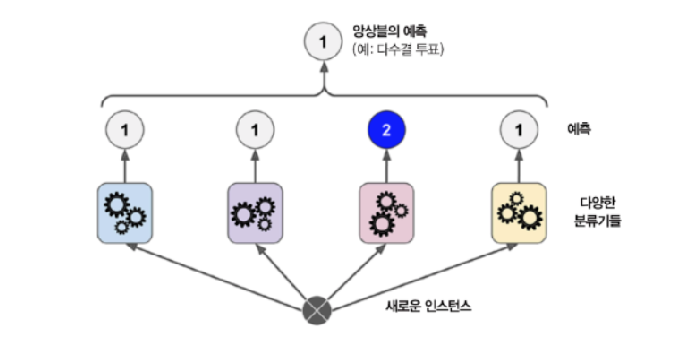

In [2]:
import matplotlib.image as mpimg

voting_classe_img = mpimg.imread("./images/voting_classification.png")
plt.figure(figsize=(12, 6))
plt.imshow(voting_classe_img)
plt.axis("off")
plt.show()

정확도가 80%인 분류기 여러 개를 훈련시켰다고 가정  
더 좋은 분류기를 만드는 매우 간단한 방법은 각 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측   
이렇게 다수결 투표로 정해지는 분류기를 hard voting 분류기라고 함  

조금 놀랍게도 이 다수결 투표 분류기가 앙상블에 포함된 개별 분류기 중 가장 뛰어난 것보다도 정확도가 높을 경우가 많음  
사실 각 분류기가 weak learner일지라도 충분하게 많고 다양하다면 앙상블은 strong learner가 될 수 있음  

동전을 던졌을 때 앞면이 51%, 뒷면이 49%가 나오는 조금 균형이 맞지 않는 동전이 있다고 가정할 때  
이 동전을 1,000번 던진다면 대략 510번은 앞면, 490번은 뒷면이 나올 것이므로 다수는 앞면이 됨.  

수학적으로 계산해보면 1000번과, 10,000번의 앞면이 나올 확률은 아래와 같음  
```python
1-scipy.stats.binom.cdf(499, 1000, 0.51) = 0.74
1-scipy.stats.binom.cdf(4999, 10000, 0.51) = 0.978
```
이는 law of large numbers 때문임  
동전을 자꾸 던질수록 앞면이 나오는 비율이 점점 더 앞면이 나올 확률(51%)에 가까워짐  

In [3]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

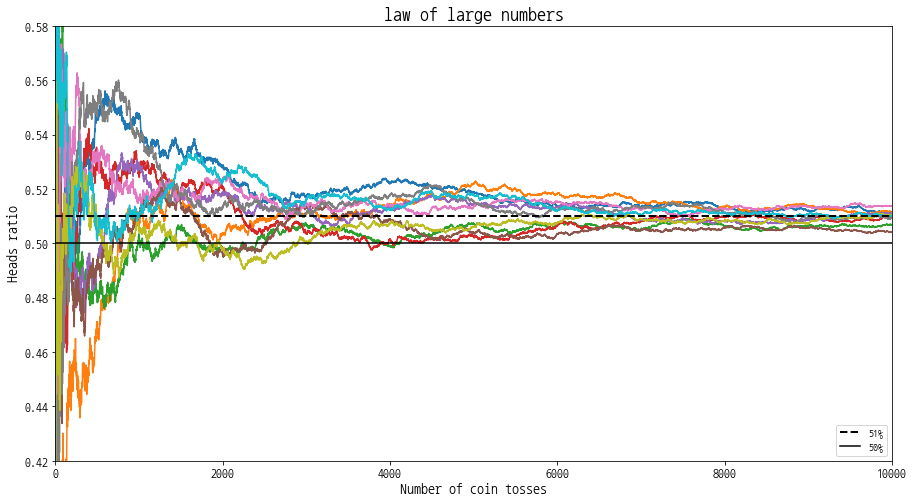

In [4]:
plt.figure(figsize=(15, 8))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.title("law of large numbers", fontsize=18)
plt.axis([0, 10000, 0.42, 0.58])

plt.show()

* 동전을 자꾸 던질수록 앞면이 나오는 비율은 점점 더 앞면이 나올 확률(51%)에 가까워짐  
* 던진 횟수가 증가할수록 앞면이 나올 확률이 51%에 가까워짐 

---

* 이와 비슷하게 51% 정확도를 가진 1,000개의 분류기로 앙상블 모델을 구축한다고 가정하면  
가장 많은 클래스를 예측으로 삼는다면 75%의 정확도를 기대할 수 있음  
* 하지만 이런 가정은 모든 분류기가 완벽하게 독립적이고 오차에 상관관계가 없어야 가능 -> 하지만 여기서는 같은 데이터로 훈련시키기 때문에 이런 가정이 맞지 않음  
* 분류기들이 같은 종류의 오차를 만들기 쉽기 때문에 잘못된 클래스가 다수인 경우가 많고 앙상블의 정확도가 낮아짐  

>앙상블 방법은 예측기가 가능한 한 서로 독립적일 때 최고의 성능을 발휘함. 다양한 분류기를 얻는 방법은 각기 다른 알고리즘으로 학습시키는 것  
이렇게 하면 매우 다른 종류의 오차를 만들 가능성이 높기 때문에 앙상블 모델의 정확도를 향상시킴

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="liblinear", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma="auto", random_state=42, probability=True)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard', n_jobs=-1)

In [7]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', Rando...bf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=-1, voting='hard', weights=None)

In [8]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


* 모든 분류기가 클래스의 확률을 예측할 수 있으면 개별 분류기의 예측을 평균 내어 확률이 가장 높은 클래스를 예측할 수 있음  
* 이를 간접 투표(soft voting)  
* 이 방식은 확률이 높은 투표에 비중을 더 두기 때문에 직접 투표 방식보다 성능이 높음  
* 이 방식을 사용하기 위해서는 voting="hard"를 voting="soft"로 바꾸고 모든 분류기가 클래스의 확률을 추정할 수 있음  
* SVC는 기본값에서 클래스 확률을 제공하지 않으므로 probability 매개변수를 True로 지정해야 함  

In [9]:
log_clf = LogisticRegression(solver="liblinear", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma="auto", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft', n_jobs=-1)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', Rando...bf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=-1, voting='soft', weights=None)

In [10]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


## 6-3. Bagging ensembles
앞서 말했듯이 다양한 분류기를 만드는 한 가지 방법은 각기 다른 훈련 알고리즘을 사용하는 것  
또 다른 방법은 같은 알고리즘을 사용하지만 훈련 세트의 서브셋을 무작위로 구성하여 분류기를 각기 다르게 학습시킴  

훈련 세트에서 중복을 허용하여 샘플링하는 방식을 배깅(bootstrap aggregating)이라 하며, 중복을 허용하지 않고 샘플링하는 방식을 페이스팅(pasting)이라 함  
### 6-3-1. scikit-learn의 Bagging과 pasting

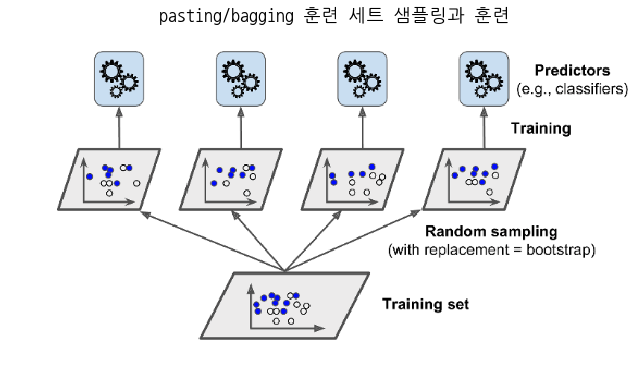

In [11]:
import matplotlib.image as mpimg

bagging_img = mpimg.imread("./images/pasting_bagging.png")
plt.figure(figsize=(12, 6))
plt.imshow(bagging_img)
plt.title("pasting/bagging 훈련 세트 샘플링과 훈련", fontsize=18)
plt.axis("off")
plt.show()

모든 예측기가 훈련을 마치면 앙상블은 모든 예측기의 예측을 모아서 새로운 샘플에 대한 예측을 만듬  
수집함수는 전형적으로 분류일 때는 통계적 최빈값(statistical mode, 직접 투표 분류기처럼 가장 많은 예측 결과)이고 회귀에 대해서는 평균을 계산함  

개별 예측기는 원본 훈련 세트로 훈련시킨 것보다 훨씬 크게 편향되어 있지만 수집 함수를 통과하면 편향과 분산이 모두 감소함  
일반적으로 앙상블의 결과는 원본 데이터셋으로 하나의 예측기를 훈련시킬 때와 비교해 편향은 비슷하지만 분산은 줄어듬  

In [12]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [13]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [14]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [15]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

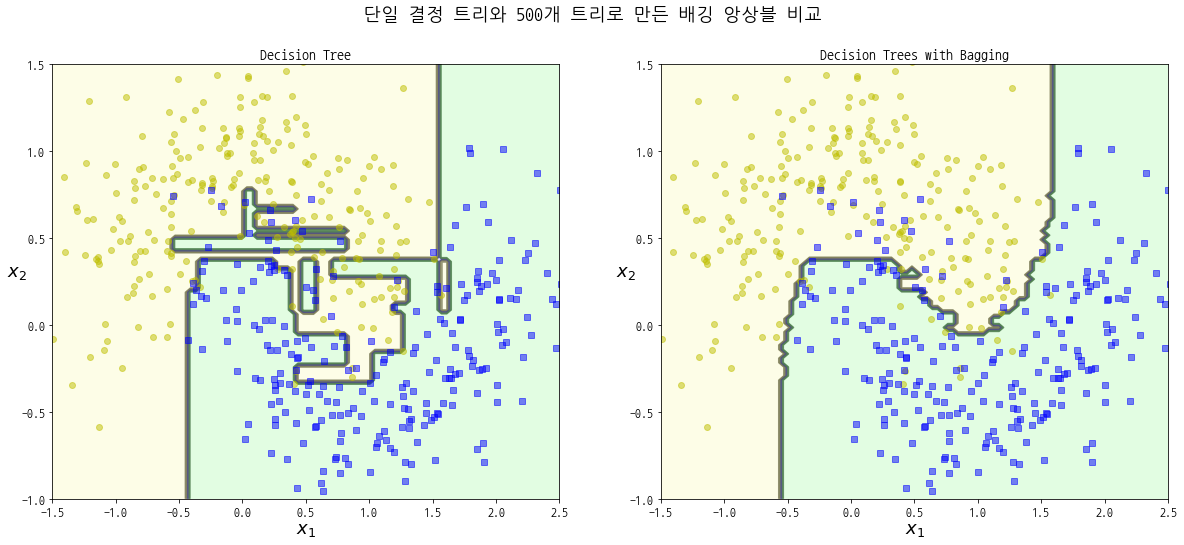

In [16]:
plt.figure(figsize=(20, 8)).suptitle("단일 결정 트리와 500개 트리로 만든 배깅 앙상블 비교", fontsize=18)
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.show()

* 단일 결정 트리의 결정 경계와 500개의 트리를 사용한 배깅 앙상블의 결정 경계를 비교한 것  
* 둘 다 moons 데이터셋에 훈련시킴  

---

* 앙상블의 예측이 결정 트리 하나의 예측보다 일반화가 더 잘됨  
* 부트스트래핑은 각 예측기가 학습하는 서브셋에 다양성을 증가시키므로 배깅이 페이스팅보다 편향이 조금 더 높음  
* 하지만 이는 예측기들의 상관관계를 줄이므로 앙상블의 분산을 감소시킴  
* 전반적으로 배깅이 더 나은 모델을 만들기 때문에 일반적으로 더 선호함  

### 6-3-2. oob(out-of-bag) 평가
#### 6-3-2-1. Random Forests

* 배깅을 사용하면 어떤 샘플은 한 예측기를 위해 여러 번 샘플링되고 어떤 것은 전혀 선택되지 않을 수 있음.  
* BaggingClassifier는 기본값으로 중복을 허용하여(bootstrap=True)훈련 세트의 크기 만큼인 $m$개 샘플을 선택함.  
* 이는 평균적으로 각 예측기에 훈련 샘플의 63% 정도만 샘플링되는 것을 의미  

>$m$이 커지면 비율이 $1-e^{-1} \approx 63.212%$에 가까워짐. m개의 샘플에서 무작위로 하나를 추출할 때 선택되지 않을 확률은 $1 - \frac{1}{m}$이고 이를 $m$번 반복했을 때도 선택되지 않을 확률은 $\left(1-\frac{1}{m} \right)^{m}$임.  
여기에 로그를 정리하고 로피탈의 정리를 적용하면 이 값이 $e^{-1}$과 같아짐.  
따라서 샘플링될 확률은 $1 - e^{-1}=0.63212$가 됨  
선택되지 않은 훈련 샘플의 나머지 37%를 oob 샘플이라 하고(예측기마다 남겨진 37%는 모두 다름)  

* 예측기가 훈련되는 동안에는 oob 샘플을 사용하지 않으므로 검증 세트나 교차 검증을 사용하지 않고 oob샘플을 사용해 평가할 수 있음  
* 앙상블의 평가는 각 예측기의 oob 평가를 평균하여 얻음  

* scikit-learn에서 BaggingClassifier를 만들 때 oob_score=True로 지정하면 훈련이 끝난 후 자동으로 oob평가를 수행함  
* 평가점수결과는 oob_score_변수에 저장되어 있음

In [17]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9013333333333333

In [18]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

* 테스트 세트에서 91.2%의 정확도를 얻음  
* oob 샘플에 대한 결정 함수의 값도 oob_decision_function_ 변수에서 확인할 수 있음  
    * 이 경우 결정 함수는 각 훈련 샘플의 클래스 확률을 반환(기반이 되는 예측기가 predict_proba() 메서드를 가지고 있기 때문) 

In [19]:
bag_clf.oob_decision_function_[:10]

array([[0.31746032, 0.68253968],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.08379888, 0.91620112],
       [0.31693989, 0.68306011],
       [0.02923977, 0.97076023],
       [0.97687861, 0.02312139],
       [0.97765363, 0.02234637]])

## 6-4. 랜덤 패치와 랜덤 서브스페이스
## 6-5. Random Forests

Random Forest는 일반적으로 bagging(pasting)을 적용한 결정트리의 ensamble임  
전형적으로 max_samples를 훈련 세트의 크기로 지정  
Bagging Classifier에 DecisionTreeClassifier를 넣어 만드는 대신 결정 트리에 최적화되어 사용하기 편리한 RandomForestClassifier를 사용할 수 있음

In [20]:
from sklearn.ensemble import RandomForestClassifier

# 최대 16개의 리프노드를 갖는 500개의 트리로 이뤄진 Random_forest를 병렬 처리
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [18]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # almost identical predictions

0.976

* RandomForestClassifier는 몇 가지 예외가 있지만 (트리 성장의 조절을 위한) DecisionTreeClassifier의 매개변수와 ensemble 자체를 제어하는 데 필요한 BaggingClassifier의 매개변수를 모두 가지고 있음  
* RandomForest 알고리즘은 트리의 노드를 분할할 때 전체 특성 중에서 최선의 특성을 찾는 대신 무작위로 선택한 특성 후보 중에서 최적의 특성을 찾는 식으로 무작위성을 더 주입  
* 이는 결국 트리를 더욱 다양하게 만들고 편향을 손해 보는 대신 분산을 낮추어 전체적으로 더 훌륭한 모델을 만들어냄  
* BaggingClassifier를 사용해 앞의 RandomForestClassifier와 유사하게 만듬  

### 6-5-1. Feature importance

* 랜덤 포레스트의 또 다른 장점은 특성의 상대적 중요도를 측정하기 쉽다는 것  
* scikit-learn은 어떤 특성을 사용한 노드가 (랜덤 포레스트에 있는 모든 트리에 걸쳐서) 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도를 측정  
* 즉, 가중치 평균이며 각 노드의 가중치는 연관된 훈련 샘플 수와 같음  

---

* 사이킷런은 훈련이 끝난 뒤 특성마다 자동으로 이 점수를 계산하고 중요도의 전체 합이 1이 되도록 결과값을 정규화  
* 이 값은 feature_importances_ 에 저장되어 있음  

In [28]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876374
sepal width (cm) 0.023119288282510326
petal length (cm) 0.44103046436395765
petal width (cm) 0.4233579963547681


In [29]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

* MNIST 데이터셋에 random forest 분류기를 훈련시키고 픽셀의 중요도는 다음과 같이 표현 가능

In [25]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.int64)

In [26]:
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [27]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.figure(figsize=(15, 8))
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

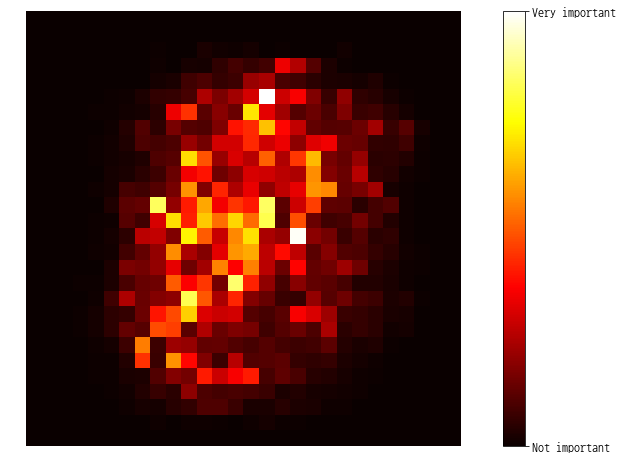

In [28]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()

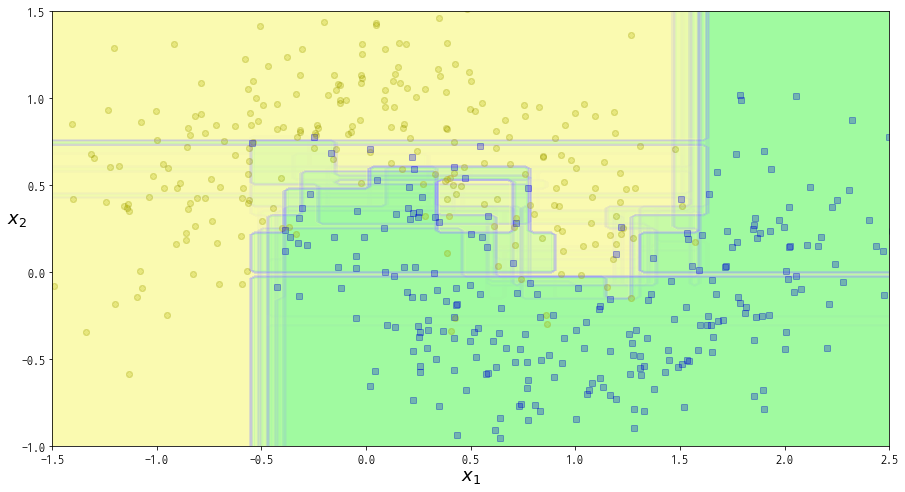

In [21]:
plt.figure(figsize=(15, 8))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.02, contour=False)

plt.show()

## 6-6. Boosting

* boosting은 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 ensemble 방법을 말함  
* 부스팅 방법의 아이디어는 앞의 모델을 보완해 나가면서 일련의 예측기를 학습시키는 것  
* **AdaBoost**(Adaptive Boosting의 줄임말)과 **Gradient Boosting**

### 6-6-1. AdaBoost

이전 예측기를 보완하는 새로운 예측기를 만드는 방법은 이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높이는 것  
이렇게 하면 새로운 예측기는 학습하기 어려운 샘플에 점점 더 맞춰지게 됨
이 것이 아다부스트에서 사용하는 방식

___

아다부스트(AdaBoost)는 과소적합(underfitted)됐던 학습 데이터 샘플의 가중치를 높이면서 새로 학습된 모델이 학습하기 어려운 데이터에 더 잘 적합되도록 하는 방식.  
아래의 그림에서 처럼 아다부스트의 단계를 설명하면 다음과 같음  
1. 먼저 전제 학습 데이터셋을 이용해 모델을 만든 후, 잘못 예측(분류)된 샘플의 가중치를 상대적으로 높여줌  
2. 그 다음 두 번째 모델을 학습 시킬때 이렇게 업데이트된 가중치를 반영하여 모델을 학습 시킴  
3. 이와 같은 과정을 반복한다.  

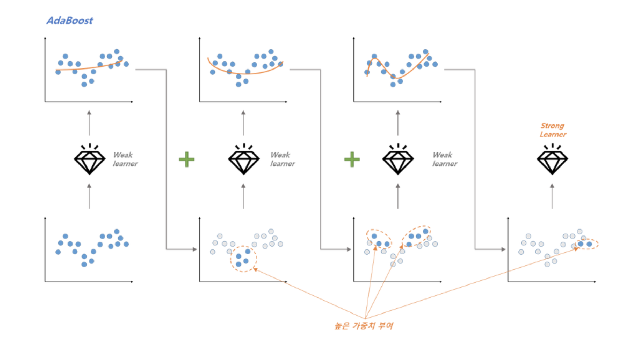

In [30]:
import matplotlib.image as mpimg

adaboostimg = mpimg.imread("./images/adaboost.png")
plt.figure(figsize=(12, 6))
plt.imshow(adaboostimg)
plt.axis("off")
plt.show()

**moons 데이터셋에 AdaBoost 적용**  
Scikit-Learn에는 AdaBoost를 사용할 수 있도록 AdaBoostClassifier를 제공  

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [32]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=42)

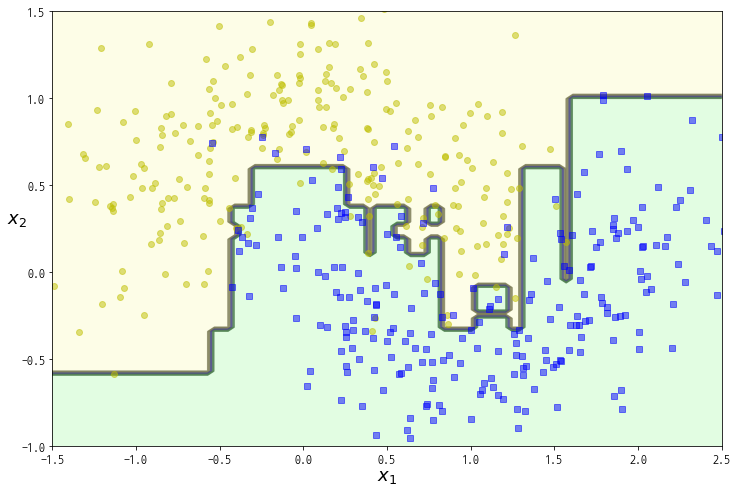

In [34]:
plt.figure(figsize=(12, 8))
plot_decision_boundary(ada_clf, X, y)

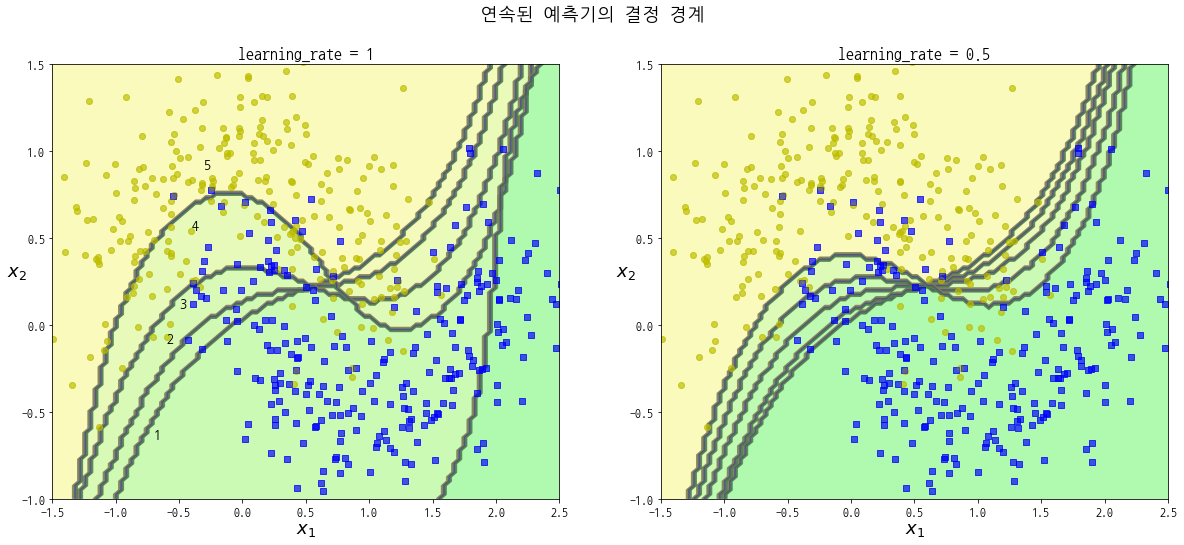

In [36]:
m = len(X_train)

plt.figure(figsize=(20, 8)).suptitle("연속된 예측기의 결정 경계", fontsize=18)
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    plt.subplot(subplot)
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma="auto", random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 121:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)

plt.show()

* 이 것은 moons 데이터셋에 훈련시킨 5개의 연속된 예측기의 결정 경계(이 모델은 규제를 강하게 한 RBF 커널 SVM 분류기임)  
* 첫번째 분류기가 많은 샘플을 잘못 분류해서 이 샘플들의 가중치가 높아졌음  
* 두번째 분류기는 이 샘플들을 더 정확하게 예측하게 됨 

---

* 오른쪽 그래프는 학습률을 반으로 낮춘 것만 빼고 같은 모델임(잘못 분류된 샘플의 가중치는 반복마다 절반 정도만 높아짐)  
* 이는 연속된 학습 기법은 경사 하강법과 비슷한 면이 있음  
* 경사하강법은 비용 함수를 최소화하기 위해 한 예측기의 모델 파라미터를 조정해가는 반면 아다부스트는 점차 더 좋아지도록 ensemble에 예측기를 추가함  

> 연속된 학습 기법에는 이전 예측기가 훈련되고 평가된 후에 학습될 수 있기 때문에 병렬화를 할 수 없음  
결국 배깅이나 페이스팅만큼 확장성이 높지 않음

In [32]:
list(m for m in dir(ada_clf) if not m.startswith("_") and m.endswith("_"))

['base_estimator_',
 'classes_',
 'estimator_errors_',
 'estimator_weights_',
 'estimators_',
 'feature_importances_',
 'n_classes_']

### 6-6-2. Gradient Boosting

* 그래디언트 부스팅은 의사결정나무(decision tree) 알고리즘을 이용해 그래디언트 부스팅을 사용  
* 이를 그래디언트 트리 부스팅 또는 그래디언트 부스티드 회귀 트리(GRBT)라고 함  

$$y=3X^{2}+0.05+noise$$

In [40]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [41]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

처음 학습시킨 모델 `tree_reg1`에 대한 잔여 오차(residual error)를 구한 뒤 이것을 가지고 두번째 `DecisionTreeRegressor`모델 학습  

In [42]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

두 번째 예측기가 만든 잔여 오차에 세 번째 회귀 모델을 훈련시킴

In [43]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [44]:
X_new = np.array([[0.8]])

In [45]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [46]:
y_pred

array([0.75026781])

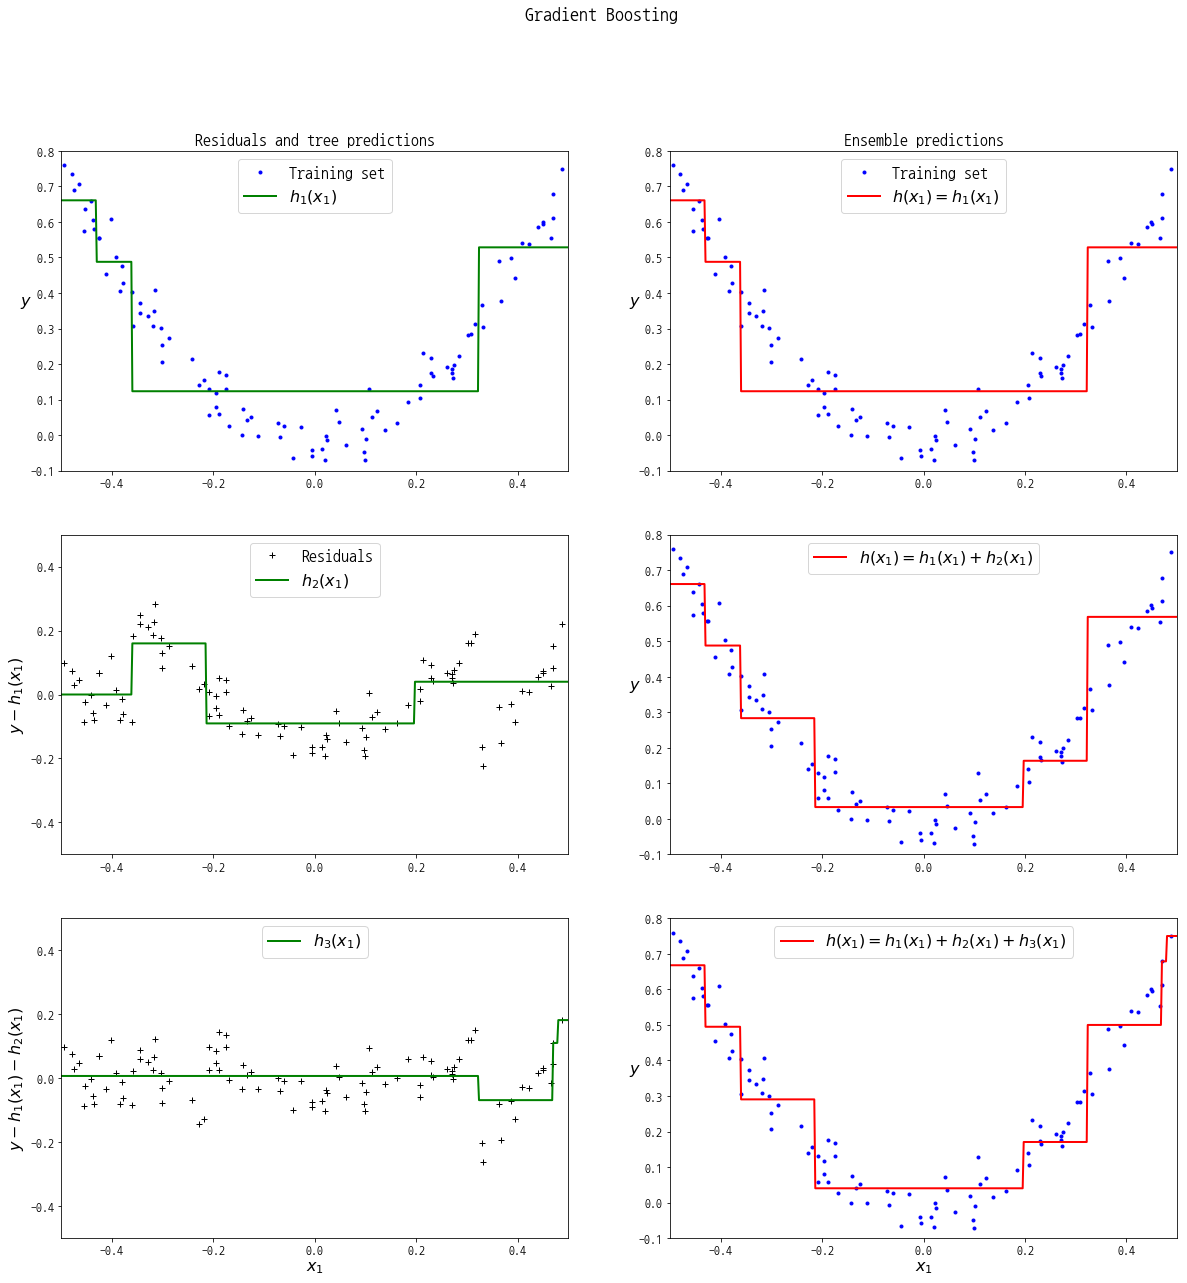

In [58]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(20,20)).suptitle("Gradient Boosting", fontsize=18)

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

* 이 그림의 왼쪽 열은 이 **세 트리의 예측**이고 오른쪽 열은 **앙상블의 예측**임  
* 첫 번째 행에서는 앙상블에 트리가 하나만 있어서 첫 번째 트리의 예측과 완전히 같음  
* 두 번째 행에서는 새로운 트리가 첫 번째 트리의 잔여 오차에 대해 학습됨  
* 오른쪽의 앙상블 예측이 이 두 개의 트리 예측의 합과 같은 것을 볼 수 있음  
* 비슷하게 세 번째 행에서는 또 다른 트리가 두 번째 트리의 잔여 오차에 훈련되었음  
* 트리가 앙상블에 추가될수록 앙상블의 예측이 점차 좋아지는 것을 알 수 있음  

---

* scikit-learn의 GradientBoostingRegressor를 사용하면 GBRT ensemble을 간단하게 훈련시킬 수 있음  
* 트리 수(n_estimators)와 같이 앙상블의 훈련을 제어하는 매개변수는 물론 RandomForestRegressor와 아주 비슷하게 결정 트리의 성장을 제어하는 매개변수(max_depth, min_samples_leaf, ...)를 가지고 있음

이번에는 Scikit-Learn의 GradientBoostingRegressor를 이용해 위의 과정과 동일하게 모델링 해보면 다음과 같음  
GradientBoostingRegressor에서 learning_rate($\eta$) 인자는 학습 단계에서 각 모델(트리)의 반영 비율을 의미  

$$H_{t}(x)=H_{t-1}(x)+\eta h_{t}(x)$$

* $\eta: 0 < \eta \le 1$

이렇게 learning_rate($\eta$)를 이용하는 방법을 **축소**(shrinkage)라고 하는 **규제**(regularization)방법임  

In [51]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=1.0, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=3, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [53]:
X_new = np.array([[0.8]])
print(f"y_pred: {gbrt.predict(X_new)}")

y_pred: [0.75026781]


* 아래의 예제는 학습시킬 모델의 개수(n_estimator)를 3개와 200개로 했을 때의 차이를 나타냄

In [55]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

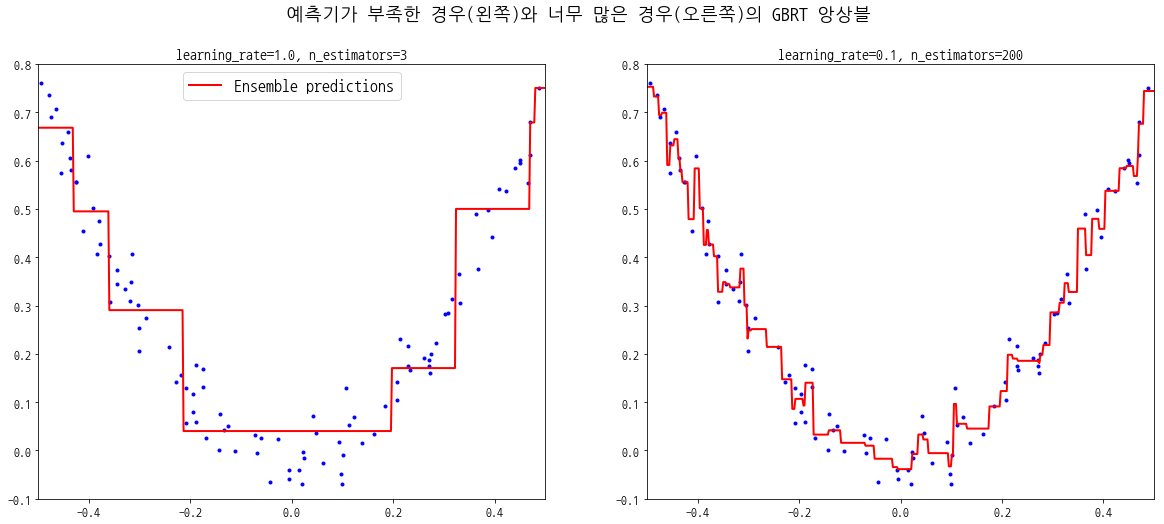

In [59]:
plt.figure(figsize=(20, 8)).suptitle("예측기가 부족한 경우(왼쪽)와 너무 많은 경우(오른쪽)의 GBRT 앙상블", fontsize=18)

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

plt.show()

### 6-6-3. Gradient Boosting with Early stopping

* 그래디언트 부스팅의 학습 단계에서 학습 시킬 최적의 트리(모델)의 개수를 찾기 위해 조기 종료(early stopping)을 사용할 수 있음  
* GBRT를 학습시킨 후 `staged_predict()` 메소드를 이용해 각 모델의 예측값(`y_pred`)과 실제값(`y_val`)의 MSE를 구한 뒤 MSE가장 낮은 최적의 트리의 개수를 찾아 다시 최적의 트리 개수(`best_n_estimator`)로 그래디언트 부스팅 학습을 진행  

In [60]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=56, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [61]:
min_error = np.min(errors)

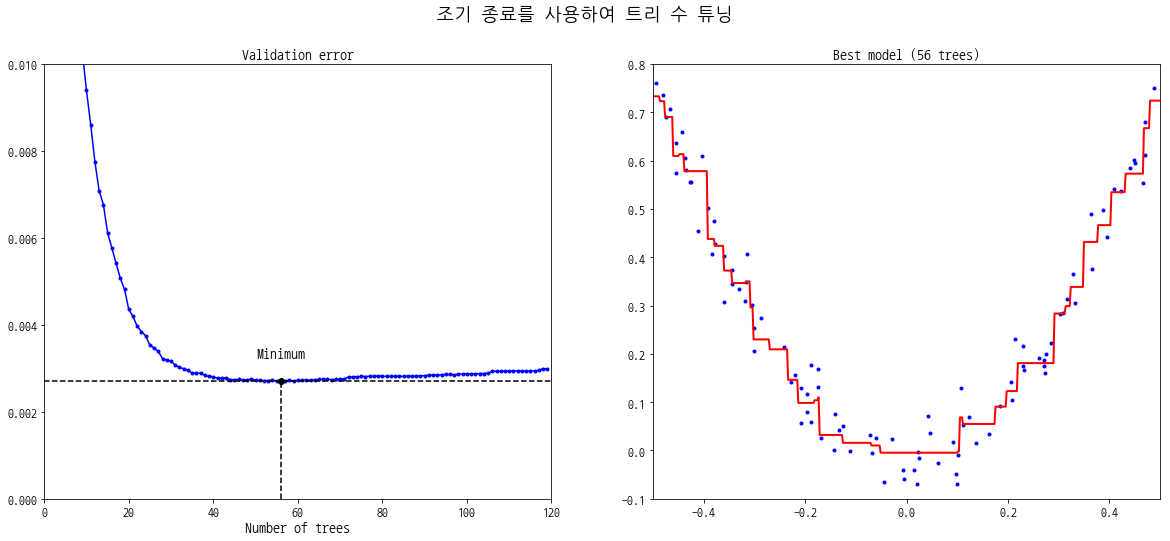

In [63]:
plt.figure(figsize=(20, 8)).suptitle("조기 종료를 사용하여 트리 수 튜닝", fontsize=18)

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)

plt.show()

In [64]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [65]:
print(gbrt.n_estimators)

61


In [66]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463


* GradientBoostingRegressor는 각 트리가 훈련할 때 사용할 훈련 샘플의 비율을 지정할 수 있는 subsample 매개변수도 지원함  
* subsample=0.25라고 하면 각 트리는 무작위로 선택된 25% 훈련 샘플로 학습됨  
* 편향이 높아지는 대신 분산이 낮아지게 됨  
* 이런 기법을 **Stochastic Gradient Boosting**(확률적 그래디언트 부스팅)이라고 함

### 6-6-4. XGBoost

In [68]:
import xgboost

In [69]:
xgb_reg = xgboost.XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred)
print("Validation MSE:", val_error)

[16:23:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation MSE: 0.0028512559726563943


In [70]:
xgb_reg.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred)
print("Validation MSE:", val_error)

[16:23:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.286719
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.258221
[2]	validation_0-rmse:0.232634
[3]	validation_0-rmse:0.210526
[4]	validation_0-rmse:0.190232
[5]	validation_0-rmse:0.172196
[6]	validation_0-rmse:0.156394
[7]	validation_0-rmse:0.142241
[8]	validation_0-rmse:0.129789
[9]	validation_0-rmse:0.118752
[10]	validation_0-rmse:0.108388
[11]	validation_0-rmse:0.100155
[12]	validation_0-rmse:0.09208
[13]	validation_0-rmse:0.084791
[14]	validation_0-rmse:0.078699
[15]	validation_0-rmse:0.073248
[16]	validation_0-rmse:0.069391
[17]	validation_0-rmse:0.066277
[18]	validation_0-rmse:0.063458
[19]	validation_0-rmse:0.060326
[20]	validation_0-rmse:0.0578
[21]	validation_0-rmse:0.055643
[22]	validation_0-rmse:0.053943
[23]	validation_0-rmse:0.053138
[24]	validation_0-rmse:0.052415
[25]	validation_0-rmse

In [71]:
xgboost.XGBRegressor().fit(X_train, y_train)

[16:24:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [72]:
GradientBoostingRegressor().fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

### 6-6-5. Stacking

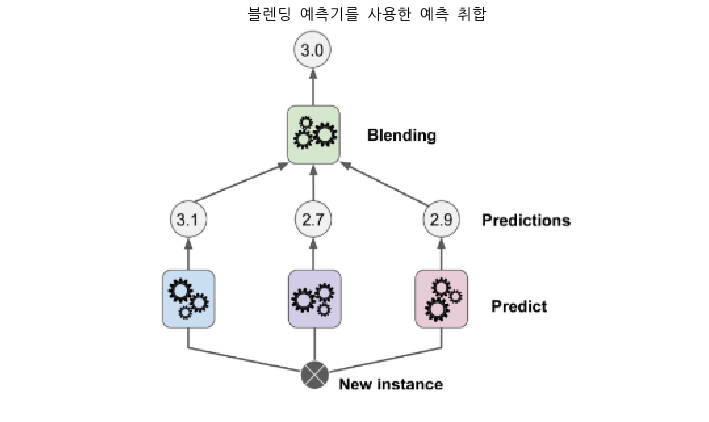

In [75]:
import matplotlib.image as mpimg

stacking_img = mpimg.imread("./images/stacking.png")
plt.figure(figsize=(12, 8))
plt.imshow(stacking_img)
plt.title("블렌딩 예측기를 사용한 예측 취합")
plt.axis("off")
plt.show()

스태킹(stacking, stacked generalization의 줄임)은 '1 - 투표 기반 분류기'에서 처럼 'hard voting', 'soft voting' 방법이 아니라 앙상블 학습에서 각 모델의 예측값을 가지고 새로운 메타 모델(meta learner)을 학습시켜 최종 예측 모델을 만드는 방법을 말함  

**스태킹(stacking)의 과정은 다음과 같음**  
1. 학습 데이터셋에서 샘플링을 통해 서브셋1(subset-1)을 만들고, 이 서브셋을 이용해 각 모델을 학습  
2. 서브셋2(subset-2) 학습 시킨 모델을 이용해 각 모델의 예측값을 출력하고 예측값들을 합침  
3. 합쳐진 예측값들을 입력 특성(input feature)로 사용하는 새로운 모델(meta learner, blender)을 학습  

## 6-7. Exercise

1. 정확히 같은 훈련 데이터로 다섯 개의 다른 모델을 훈련시켜서 모두 95% 정확도를 얻었다면 이 모델들을 연결하여 더 좋은 결과를 얻을 수 있을까? 가능하다면 어떻게 해야하는가?  
2. 직접 투표와 간전 투표 분류기 사이의 차이점은 무엇인가?  
3. 배깅 앙상블의 훈련을 여러 대의 서버에 분산시켜 속도를 높일 수 있을까? 페이스팅 앙상블, 부스팅 앙상블, 랜덤포레스트, 스태킹 앙상블의 경우는 어떠한가?  
4. oob 평가의 장점은 무엇인가?
5. 무엇이 엑스트라 트리를 일반 랜덤 포레스트보다 더 무작위하게 만드는가? 추가적인 무작위성이 어떻게 도움이 될까? 엑스트라 트리는 일반 랜덤 포레스트보다 느린가? 빠른가?
6. 아다부스트 앙상블이 훈련 데이터에 과소적합되었다면 어떤 매개변수를 어떻게 바꾸어야 하는가?
7. 그래디언트 부스팅 앙상블이 훈련 데이터에 과대적합되었다면 학습률을 높여야 하는가? 낮춰야 하는가?
8. MNIST 데이터를 불러들여 훈련 세트, 검증 세트, 테스트 세트로 나눔(훈련: 40,000개, 검증: 10,000개, 테스트: 10,000), 그런 다음 랜덤 포레스트 분류기, 엑스트라 트리 분류기, SVM같은 여러 종류의 분류기를 훈련시킴  
그리고 검증 세트에서 개개의 분류기보다 더 높은 성능을 내도록 이들을 간접 또는 직접 투표 분류기를 사용하는 앙상블로 연결해보면 개개의 분류기와 비교해서 성능이 얼마나 향상되는가? 